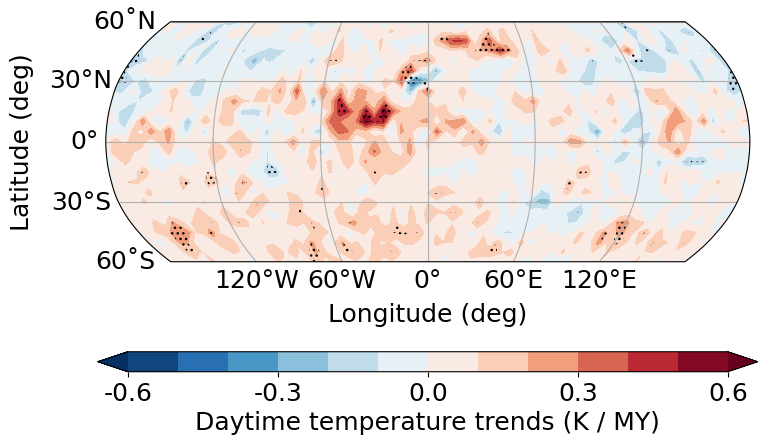

In [ ]:
import warnings
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib as mpl
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from scipy.stats import theilslopes
import pymannkendall as mk

# Suppress warnings
warnings.filterwarnings("ignore")

# ==========================================
# 1. DATA PROCESSING & STATISTICS
# ==========================================

def get_continuous_time(da: xr.DataArray) -> xr.DataArray:
    """
    Collapse Mars Year (MY) and Ls into a single continuous fractional coordinate.
    """
    # Create new continuous coordinate (MY + Ls/360)
    my_frac = da.coords["MY"] + da.coords["Ls"] / 360
    
    # Stack MY and Ls into one dimension
    da_stacked = da.stack(sample=("MY", "Ls"))
    
    # Assign new continuous coordinate and rename to MY for consistency
    da_stacked = da_stacked.assign_coords(sample=my_frac.values.flatten())
    da_stacked = da_stacked.rename({"sample": "MY"})
    
    return da_stacked

def calculate_trend_ufunc(y, x=None):
    """
    Computes Theil-Sen slope and Mann-Kendall significance.
    Includes outlier removal (< 2 std dev).
    """
    if x is None:
        x = np.arange(len(y))
        
    # Mask NaNs
    mask = ~np.isnan(y)
    y = y[mask]
    x = x[mask]
    
    # Outlier Removal (Original Logic)
    y_anom = np.abs(y - np.nanmean(y))
    y_std = np.nanstd(y)
    mask = y_anom < 2 * y_std
    y = y[mask]
    x = x[mask]
    
    if len(y) < 2:
        return np.nan, np.nan
        
    slope, intercept, lower_slope, upper_slope = theilslopes(y, x)
    p_value = mk.original_test(y).p
    
    return slope, p_value

def process_data(filepath, my_range, lat_range, ltst):
    """
    Loads data, applies masks, calculates anomalies, and computes trends.
    """
    myS, myN = my_range
    latS, latN = lat_range
    
    ds_mcs = xr.open_dataset(filepath)
    da_mcs = ds_mcs['tsurf_correct'].loc[myS:myN, :, ltst, latS:latN]

    # Apply MY34 Dust Storm Mask
    mask = (da_mcs.MY == 34) & (da_mcs.Ls > 180) & (da_mcs.Ls < 250)
    da_mcs = da_mcs.where(~mask)

    # Calculate Climatology and Anomaly
    da_mcs_clim = da_mcs.mean(dim='MY')
    da_mcs_anom = da_mcs - da_mcs_clim
    
    # Linearize time
    da_mcs_anom = get_continuous_time(da_mcs_anom)

    # Apply Trend Calculation
    result = xr.apply_ufunc(
        calculate_trend_ufunc,
        da_mcs_anom,
        da_mcs_anom.MY,
        input_core_dims=[["MY"], ["MY"]],
        output_core_dims=[[], []],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float, float],
    )
    
    slope, p_value = result
    slope.name = "slope"
    p_value.name = "p_value"
    
    return slope, p_value

# ==========================================
# 2. PLOTTING (Original Styling Preserved)
# ==========================================

def add_axes(fig, pos, title=''):
    ax = fig.add_axes(pos, projection=ccrs.Robinson())
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 18} 
    gl.ylabel_style = {'size': 18}
    
    gl.xlocator = mticker.FixedLocator(np.arange(-120, 180, 60))
    gl.ylocator = mticker.FixedLocator(np.arange(-60, 61, 30))
    
    ax.text(0.03, 1.0, '60˚N', ha='center', va='center', transform=ax.transAxes, fontsize=18)
    ax.text(0.03, 0.0, '60˚S', ha='center', va='center', transform=ax.transAxes, fontsize=18)
    
    ax.text(0.5, -0.22, 'Longitude (deg)', ha='center', va='center', transform=ax.transAxes, fontsize=18)
    ax.text(-0.13, 0.5, 'Latitude (deg)', ha='center', va='center', transform=ax.transAxes, fontsize=18, rotation='vertical')

    # Tick mark configuration
    ax.tick_params('both', which='both', top=False, right=False, labelsize=18)
    ax.set_title(title, loc='center', fontdict={'fontsize': 18})
    
    return ax

def plot_figure(slope, p_value, lat_range=(-60, 60), lon_range=(-180, 180)):
    # Prepare data for plotting
    lon = slope['Lon'].loc[lon_range[0]:lon_range[1]]
    lat = slope['Lat'].loc[lat_range[0]:lat_range[1]]

    cycle_slope, cycle_lon = add_cyclic_point(slope, coord=lon)
    cycle_p_value, _ = add_cyclic_point(p_value, coord=lon)

    fig = plt.figure(figsize=(20, 20))

    # Main Map Axis
    ax1 = add_axes(fig, [0.12, 0.70, 0.4, 0.12], '',)
    
    contourf_kw = dict(
        transform=ccrs.PlateCarree(),
        levels=np.arange(-0.6, 0.61, 0.1),
        cmap=mpl.cm.RdBu_r,
        add_colorbar=False,
        add_labels=False,
        vmin=-0.6,
        vmax=0.6,
        extend='both',
        zorder=0
    )

    # Plot Contours
    c1 = ax1.contourf(cycle_lon, lat, cycle_slope, **contourf_kw)
    
    # Plot Stippling
    ax1.contourf(cycle_lon, lat, cycle_p_value, [0, 0.025, 1], zorder=1, 
                 hatches=['...', None], colors="none", transform=ccrs.PlateCarree())
    
    # Colorbar
    position = fig.add_axes([0.155, 0.645, 0.33, 0.01])
    cbar = fig.colorbar(c1, cax=position, orientation='horizontal', format='%.1f')
    
    # Colorbar Ticks and Labels
    cbar.ax.set_xticks(np.arange(-0.6, 0.61, 0.2))
    xticks = np.arange(-0.6, 0.61, 0.3)
    xlabels = [f'{x:1.1f}' for x in xticks]
    cbar.ax.set_xticks(xticks, labels=xlabels)
    
    cbar.ax.set_xlabel('Daytime temperature trends (K / MY)', fontsize=18)
    plt.setp(cbar.ax.get_xticklabels(), fontsize=18)
    
    plt.show()

# ==========================================
# 3. MAIN EXECUTION
# ==========================================

if __name__ == "__main__":
    # Parameters
    FILE_PATH = '../data/MCS_tsurf_corrected.nc'
    MY_RANGE = (29, 36)
    LAT_RANGE = (-60, 60)
    LTST = 15

    # 1. Compute
    slope, p_value = process_data(FILE_PATH, MY_RANGE, LAT_RANGE, LTST)

    # 2. Plot
    plot_figure(slope, p_value, LAT_RANGE)

Processing LTST=15...
Processing LTST=3...


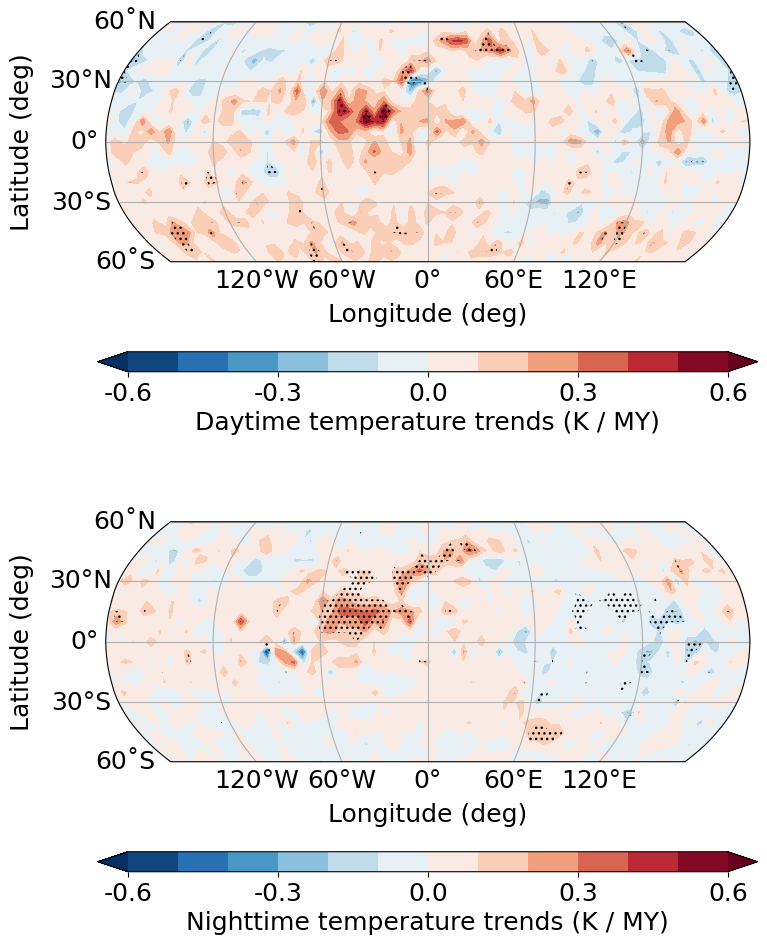

In [2]:
import warnings
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib as mpl
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from scipy.stats import theilslopes
import pymannkendall as mk

# Suppress warnings
warnings.filterwarnings("ignore")

# ==========================================
# 1. DATA PROCESSING & STATISTICS
# ==========================================

def get_continuous_time(da: xr.DataArray) -> xr.DataArray:
    """Collapse Mars Year (MY) and Ls into a single continuous fractional coordinate."""
    my_frac = da.coords["MY"] + da.coords["Ls"] / 360
    da_stacked = da.stack(sample=("MY", "Ls"))
    da_stacked = da_stacked.assign_coords(sample=my_frac.values.flatten())
    da_stacked = da_stacked.rename({"sample": "MY"})
    return da_stacked

def calculate_trend_ufunc(y, x=None):
    """Computes Theil-Sen slope and Mann-Kendall significance with outlier removal."""
    if x is None:
        x = np.arange(len(y))
        
    mask = ~np.isnan(y)
    y = y[mask]
    x = x[mask]
    
    # Outlier Removal
    y_anom = np.abs(y - np.nanmean(y))
    y_std = np.nanstd(y)
    mask = y_anom < 2 * y_std
    y = y[mask]
    x = x[mask]
    
    if len(y) < 2:
        return np.nan, np.nan
        
    slope, intercept, lower_slope, upper_slope = theilslopes(y, x)
    p_value = mk.original_test(y).p
    return slope, p_value

def process_data(filepath, my_range, lat_range, ltst):
    """Loads data, masks MY34 dust storm, and computes trends for a specific LTST."""
    print(f"Processing LTST={ltst}...")
    myS, myN = my_range
    latS, latN = lat_range
    
    ds_mcs = xr.open_dataset(filepath)
    da_mcs = ds_mcs['tsurf_correct'].loc[myS:myN, :, ltst, latS:latN]

    # Apply MY34 Dust Storm Mask
    mask = (da_mcs.MY == 34) & (da_mcs.Ls > 180) & (da_mcs.Ls < 250)
    da_mcs = da_mcs.where(~mask)

    # Climatology and Anomaly
    da_mcs_clim = da_mcs.mean(dim='MY')
    da_mcs_anom = da_mcs - da_mcs_clim
    da_mcs_anom = get_continuous_time(da_mcs_anom)

    # Trend Calculation
    result = xr.apply_ufunc(
        calculate_trend_ufunc,
        da_mcs_anom,
        da_mcs_anom.MY,
        input_core_dims=[["MY"], ["MY"]],
        output_core_dims=[[], []],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float, float],
    )
    
    slope, p_value = result
    slope.name = "slope"
    p_value.name = "p_value"
    
    return slope, p_value

# ==========================================
# 2. PLOTTING
# ==========================================

def add_axes(fig, pos, title=''):
    """Helper to configure map axes with specific ticks and labels."""
    ax = fig.add_axes(pos, projection=ccrs.Robinson())
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 18} 
    gl.ylabel_style = {'size': 18}
    
    gl.xlocator = mticker.FixedLocator(np.arange(-120, 180, 60))
    gl.ylocator = mticker.FixedLocator(np.arange(-60, 61, 30))
    
    ax.text(0.03, 1.0, '60˚N', ha='center', va='center', transform=ax.transAxes, fontsize=18)
    ax.text(0.03, 0.0, '60˚S', ha='center', va='center', transform=ax.transAxes, fontsize=18)
    
    ax.text(0.5, -0.22, 'Longitude (deg)', ha='center', va='center', transform=ax.transAxes, fontsize=18)
    ax.text(-0.13, 0.5, 'Latitude (deg)', ha='center', va='center', transform=ax.transAxes, fontsize=18, rotation='vertical')

    ax.tick_params('both', which='both', top=False, right=False, labelsize=18)
    ax.set_title(title, loc='center', fontdict={'fontsize': 18})
    return ax

def plot_panel(fig, slope, p_value, axes_pos, cbar_pos, cbar_label, lon_range=(-180, 180)):
    """Draws a single map panel and its colorbar."""
    lat = slope['Lat']
    lon = slope['Lon'].loc[lon_range[0]:lon_range[1]]

    cycle_slope, cycle_lon = add_cyclic_point(slope, coord=lon)
    cycle_p_value, _ = add_cyclic_point(p_value, coord=lon)

    # 1. Create Axis
    ax = add_axes(fig, axes_pos, '',)
    
    # 2. Contour Plot
    contourf_kw = dict(
        transform=ccrs.PlateCarree(),
        levels=np.arange(-0.6, 0.61, 0.1),
        cmap=mpl.cm.RdBu_r,
        add_colorbar=False,
        add_labels=False,
        vmin=-0.6,
        vmax=0.6,
        extend='both',
        zorder=0
    )
    c1 = ax.contourf(cycle_lon, lat, cycle_slope, **contourf_kw)
    
    # 3. Stippling (Significance)
    ax.contourf(cycle_lon, lat, cycle_p_value, [0, 0.025, 1], zorder=1, 
                hatches=['...', None], colors="none", transform=ccrs.PlateCarree())
    
    # 4. Colorbar
    cbar_ax = fig.add_axes(cbar_pos)
    cbar = fig.colorbar(c1, cax=cbar_ax, orientation='horizontal', format='%.1f')
    
    cbar.ax.set_xticks(np.arange(-0.6, 0.61, 0.2))
    xticks = np.arange(-0.6, 0.61, 0.3)
    xlabels = [f'{x:1.1f}' for x in xticks]
    cbar.ax.set_xticks(xticks, labels=xlabels)
    
    cbar.ax.set_xlabel(cbar_label, fontsize=18)
    plt.setp(cbar.ax.get_xticklabels(), fontsize=18)

def plot_figure(data_day, data_night, lat_range, lon_range=(-180, 180)):
    slope_day, p_day = data_day
    slope_night, p_night = data_night

    # Use original figsize
    fig = plt.figure(figsize=(20, 20))

    # --- Panel 1: Daytime (Original Position) ---
    # Plot: [left, bottom, width, height]
    # Cbar: [left, bottom, width, height]
    plot_panel(
        fig, slope_day, p_day, 
        axes_pos=[0.12, 0.70, 0.4, 0.12], 
        cbar_pos=[0.155, 0.645, 0.33, 0.01],
        cbar_label='Daytime temperature trends (K / MY)',
        lon_range=lon_range
    )

    # --- Panel 2: Nighttime (New Position) ---
    # Shifted down by 0.25 units to sit below the first plot
    plot_panel(
        fig, slope_night, p_night, 
        axes_pos=[0.12, 0.45, 0.4, 0.12], 
        cbar_pos=[0.155, 0.395, 0.33, 0.01],
        cbar_label='Nighttime temperature trends (K / MY)',
        lon_range=lon_range
    )
    
    plt.show()

# ==========================================
# 3. MAIN EXECUTION
# ==========================================

if __name__ == "__main__":
    # Parameters
    FILE_PATH = '/share/home/dynamo2/wangyu/scripts/work6/manuscripts/archive/data/MCS_tsurf_corrected.nc'
    MY_RANGE = (29, 36)
    LAT_RANGE = (-60, 60)
    
    # 1. Compute Daytime (LTST 15)
    slope_day, p_day = process_data(FILE_PATH, MY_RANGE, LAT_RANGE, ltst=15)
    
    # 2. Compute Nighttime (LTST 3)
    slope_night, p_night = process_data(FILE_PATH, MY_RANGE, LAT_RANGE, ltst=3)

    # 3. Plot Both
    plot_figure(
        data_day=(slope_day, p_day),
        data_night=(slope_night, p_night),
        lat_range=LAT_RANGE
    )